# Experiment on Different Time-series Similarity Measures 1

### Loading

In [16]:
# load image and libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from itertools import groupby
from scipy import signal
from sklearn import preprocessing
import pandas as pd
import time

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 150 # 200 e.g. is really fine, but slower

root_path = './processed_datasets/'
datasets = ['has', 'sp', 'fp', 'rb', 'sd', 'sr', 'hasb', 'ihas']

# load ground truth
ori_data_X = []
ori_data_y = []
sketch_X = []
for dataset in datasets:
    file_name = root_path + 'original_' + dataset  
    ori_data_X.append(np.load(file_name + '_X' + '.npy'))
    ori_data_y.append(np.load(file_name + '_y' + '.npy'))
    file_name = root_path + 'sketch_' + dataset + '.npy'
    sketch_X.append(np.load(file_name, allow_pickle=True)[:100])
print(f"number of loaded samples per class: {[len(x) for x in sketch_X]}")
print(f"Original data: {len(ori_data_X)} datasets")
print(f"Sketch data: {len(sketch_X)} datasets")


number of loaded samples per class: [100, 100, 100, 100, 100, 100, 100, 100]
Original data: 8 datasets
Sketch data: 8 datasets


### Sliding Window

In [17]:
def sliding_window(ori_series, clip_series, measure):
    """
    Compute the similarities of the original and the clipped series using sliding window
    input: original time series, clipped series, similarity measure function
    output: similarity_distribution, matching result, i.e., starting and ending points
    """
    ori_len = ori_series.shape[0]
    clip_len = clip_series.shape[0]
    if ori_len < clip_len:
        return None

    # compute the similarity between the original and the clipped series
    dist = []
    # compute the similarity between the original and the clipped series using sliding window
    for i in range(ori_len - clip_len + 1):
        dist.append(measure(ori_series[i:i+clip_len], clip_series))
    # find the maximum similarity and the corresponding starting and ending points
    min_idx = np.argmin(dist)
    return dist, [min_idx, min_idx + clip_len - 1]


In [18]:
def pointwise_exp(ori_data_X, ori_data_y, sketch_X, measure):
    results = []
    for i, dataset in enumerate(datasets):
        original = ori_data_X[i]
        label = ori_data_y[i]
        dummy_record = []
        for sample in sketch_X[i]:
            clip =  signal.resample(sample, label[1]-label[0]+1)
            sim_dist, pred_loc = sliding_window(original, clip, measure)
            dummy_record.append([sim_dist, pred_loc])
        results.append(dummy_record)
    return results

### Define Metrics

#### Euclidean Distance

In [19]:
def euclidean_distance(x,y):
    t = preprocessing.Normalizer()
    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)
    return np.linalg.norm(t.transform(x) - t.transform(y))

#### Mahattan Distance

In [20]:
def mahattan_distance(x,y):
    t = preprocessing.Normalizer()
    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)
    return np.abs(t.transform(x) - t.transform(y)).sum()

#### Dynamic Time Warping (DTW)
Based on tslearn: https://github.com/tslearn-team/tslearn/

In [21]:
from tslearn.metrics import dtw
def dtw_distance(x,y):
    t = preprocessing.Normalizer()
    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)
    return dtw(t.transform(x)[0], t.transform(y)[0])

#### Canonical Time Warping (CTW)
Based on tslearn: https://github.com/tslearn-team/tslearn/

Canonical Time Warping is a method to align time series under rigid registration of the feature space. It should not be confused with Dynamic Time Warping (DTW), though CTW uses DTW.

In [22]:
from tslearn.metrics import ctw
def ctw_distance(x,y):
    t = preprocessing.Normalizer()
    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)
    return ctw(t.transform(x)[0], t.transform(y)[0])

#### Longest Common Subsequence (LCSS)
Based on tslearn: https://github.com/tslearn-team/tslearn/

LCSS is computed by matching indexes that are met up until the eps threshold, so it leaves some points unmatched and focuses on the similar parts of two sequences. The matching can occur even if the time indexes are different, regulated through the delta parameter that defines how far it can go. To retrieve a meaningful similarity value from the length of the longest common subsequence, the percentage of that value regarding the length of the shortest time series is returned.

According to this definition, the values returned by LCSS range from 0 to 1, the highest value taken when two time series fully match, and vice-versa. Therefore, we deine the distance to be 1-similarity.

In [23]:
from tslearn.metrics import lcss
def lcss_distance(x,y):
    t = preprocessing.Normalizer()
    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)
    return 1 - lcss(t.transform(x)[0], t.transform(y)[0])

#### Soft-DTW
Based on tslearn: https://github.com/tslearn-team/tslearn/

Improves DTW by using soft-min operator.

In [24]:
from tslearn.metrics import soft_dtw
def sdtw_distance(x,y):
    t = preprocessing.Normalizer()
    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)
    return soft_dtw(t.transform(x)[0], t.transform(y)[0])

#### Global Alignment kernel (GAK)
Based on tslearn: https://github.com/tslearn-team/tslearn/

See also: M. Cuturi, “Fast global alignment kernels,” ICML 2011.

In [25]:
from tslearn.metrics import gak
def gak_distance(x,y):
    t = preprocessing.Normalizer()
    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)
    return 1 - gak(t.transform(x)[0], t.transform(y)[0])

### MASS Algorithm (if having time to examine..)
https://github.com/matrix-profile-foundation/mass-ts

### Qetch Algorithm

In [26]:
#Qetch Algorithm -- inclomplete --

def width(series):
    # Should return width of series


    return 
    
def height(series):
    # Should return width of series

    return 

def get_LDE(sketch_split,Candidate_split,Gx,Gy):
    Rx = width(Candidate_split)/(Gx * width(sketch_split))    
    Ry = height(Candidate_split)/(Gy * height(sketch_split))  
    return (np.log(Rx)**2)+(np.log(Ry)**2)

def get_ShapeError(Sketch,Candidate,Gx,Gy,k):


    return 
def calculatDistance(Sketch, Candidate,k):
    # Calculating Global non uniform Scaling facctors
    Gx = width(Candidate)/width(Sketch)
    Gy = height(Candidate)/height(Sketch)
    # Calculating Shape error
    SE = get_ShapeError(Sketch,Candidate,Gx,Gy)
    sketch_split = np.split(Sketch,k)
    Candidate_split = np.split(Candidate,k)
    # Calculating Local distortion errors
    LDE = 0
    for i in range(k):
        LDE += get_LDE(Sketch[i],Candidate[i],Gx,Gy,k)

    # Calculating total error
    Dist = LDE + SE
    return Dist


### Experiment 1: Matching Performance

#### Analysis

In [27]:
def analyze_results(results, plot = True, show_table = True, ori_data_X=ori_data_X, ori_data_Y=ori_data_y, datasets=datasets):
    d = {'Dataset':[], 'Number of samples':[], 'Average distance':[], 'Average location error (%)':[]}
    for i in range(len(results)):
        d['Dataset'].append(datasets[i])
        d['Number of samples'].append(len(results[i]))
        d['Average distance'].append(np.mean([np.max(x[0]) for x in results[i]]))
        d['Average location error (%)'].append(np.mean([np.abs(x[1][0] - ori_data_y[i][0])/ ori_data_X[i].shape[0]*100 for x in results[i]]))
        dummy = {"Dataset": datasets[i], "Number of samples": len(results[i]), "Average distance": np.mean([np.max(x[0]) for x in results[i]]),
                 "Average location error (%)": np.mean([np.abs(x[1][0] - ori_data_y[i][0])/ ori_data_X[i].shape[0]*100 for x in results[i]])}
    df = pd.DataFrame(d)
    if show_table:
        display(df)
        display(df.iloc[:,[2,3]].describe())
        print(f'Average location error w.r.t. total length: {np.mean([np.mean([np.abs(x[1][0] - ori_data_y[i][0])/ ori_data_X[i].shape[0]*100 for x in results[i]]) for i in range(len(results))])}%')
    if plot:
        plt.figure()
        for i in range(len(results)):
            ax = plt.subplot(3,3,i+1)
            plt.tight_layout()
            plt.title(f"Dataset: {datasets[i]}")
            plt.xlabel("Time")
            plt.ylabel("Distance")
            plt.plot(results[i][0][0])
            plt.plot(results[i][0][1], [0.5, 0.5], marker='*', ls='none')
            plt.plot(ori_data_y[i], [0.5, 0.5], marker='o', color='r', ls='none')
        plt.legend(['Distance', 'Predicted', 'Ground Truth'],bbox_to_anchor=(2,0), loc='lower right')
        plt.show()
    return df

#### Get results

In [28]:
measures = [euclidean_distance, mahattan_distance, dtw_distance, lcss_distance, sdtw_distance, gak_distance]
measures = []
d = {'Method':[], 'Average location error (%)':[], 'Running time (s)':[]}
for measure in measures:
    print(f"Measure: {measure.__name__}")
    d['Method'].append(measure.__name__)
    tic = time.time()
    results = pointwise_exp(ori_data_X, ori_data_y, sketch_X, measure)
    toc = time.time()
    print(f"Time elasped: {toc-tic} seconds")
    df = analyze_results(results, plot = False)
    d['Average location error (%)'].append(df.iloc[:,3].mean())
    d['Running time (s)'].append(toc-tic)
    print('--------------------------------------------------------')
df = pd.DataFrame(d)
display(df)

,Method,Average location error (%),Running time (s)


#### Experiment 2: Matching Performance with Different level of Noise

In [29]:
measures = [euclidean_distance, mahattan_distance, dtw_distance, lcss_distance, sdtw_distance, gak_distance]
# measures = [euclidean_distance]
d = {'sigma':[], 'Method':[], 'Average location error (%)':[]}
sigmas = [0, 0.1, 0.2, 0.3, 1]
sigmas = [0,  5, 10, 15, 20]
for sigma in sigmas:
    print(f"Sigma: {sigma}")
    # ori_data_X = [x + np.random.normal(0, sigma, x.shape) for x in ori_data_X]
    ori_data_X = [x + np.random.randn(*x.shape) * sigma / 100 * np.std(x) for x in ori_data_X]
    for measure in measures:
        print(f"Measure: {measure.__name__}")
        d['sigma'].append(sigma)
        d['Method'].append(measure.__name__)
        results = pointwise_exp(ori_data_X, ori_data_y, sketch_X, measure)
        df = analyze_results(results, plot = False, show_table = False)
        d['Average location error (%)'].append(df.iloc[:,3].mean())
        print('--------------------------------------------------------')
df = pd.DataFrame(d)
display(df)

Sigma: 0
Measure: euclidean_distance
--------------------------------------------------------
Measure: mahattan_distance
--------------------------------------------------------
Measure: dtw_distance
--------------------------------------------------------
Measure: lcss_distance
--------------------------------------------------------
Measure: sdtw_distance
--------------------------------------------------------
Measure: gak_distance
--------------------------------------------------------
Sigma: 5
Measure: euclidean_distance
--------------------------------------------------------
Measure: mahattan_distance
--------------------------------------------------------
Measure: dtw_distance
--------------------------------------------------------
Measure: lcss_distance
--------------------------------------------------------
Measure: sdtw_distance
--------------------------------------------------------
Measure: gak_distance
--------------------------------------------------------
Sigma: 1

,sigma,Method,Average location error (%)
0,0,euclidean_distance,10.706529
1,0,mahattan_distance,10.330958
2,0,dtw_distance,9.313138
3,0,lcss_distance,35.766617
4,0,sdtw_distance,15.471829
5,0,gak_distance,9.586080
6,5,euclidean_distance,10.982246
7,5,mahattan_distance,10.358045
8,5,dtw_distance,10.345292
9,5,lcss_distance,35.766617


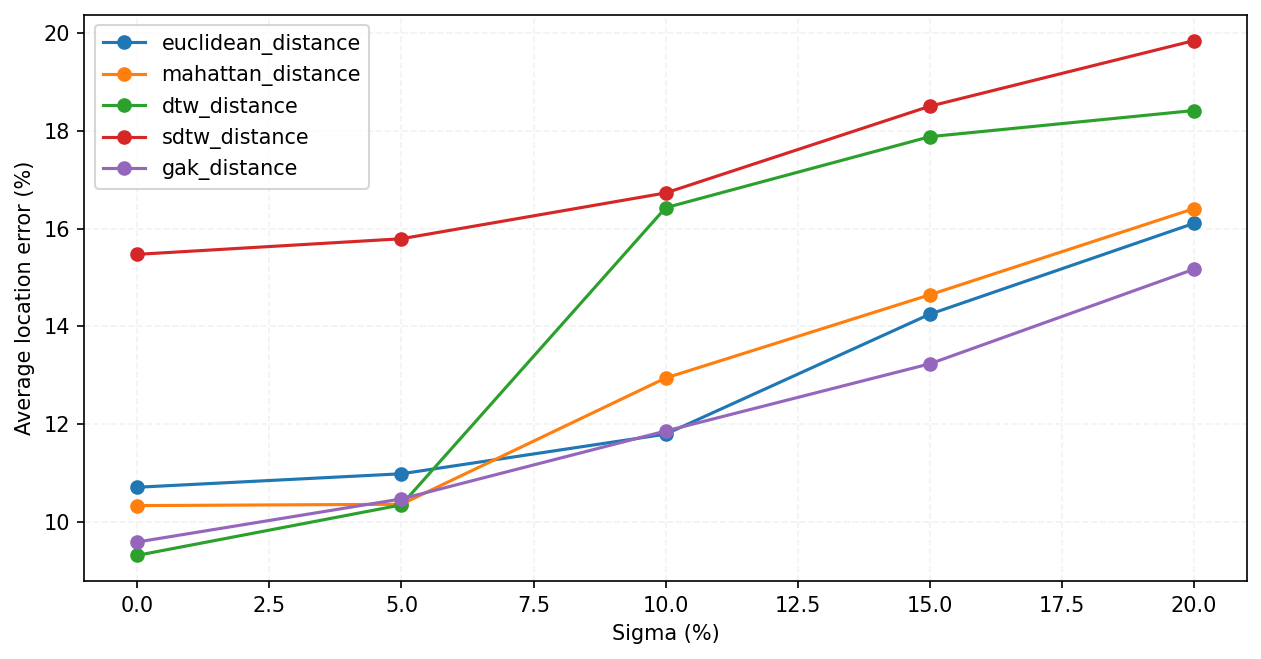

In [33]:
measures = ['euclidean_distance', 'mahattan_distance', 'dtw_distance', 'sdtw_distance', 'gak_distance']
plt.figure()
for method in measures:
    plt.plot(df[df['Method'] == method]['sigma'], df[df['Method'] == method]['Average location error (%)'], label=method, marker='o')
plt.grid(color='0.95', linestyle='--')
plt.xlabel('Sigma (%)')
plt.ylabel('Average location error (%)')
plt.legend()
plt.show()
